# Alternative loss function vs MSE

Define function to interpolate for

In [1]:
import torch
from torch import Tensor
def fn_interpolate(x: Tensor):
    return torch.exp(x)

Sample points to work with

In [2]:
N = 20
x = torch.linspace(0, 2, N)
y = fn_interpolate(x)
eps = 0.5

## Work with alternative loss function

Define ''alternative'' loss function

In [3]:
def alternative_loss(A: Tensor, lda: Tensor, f: Tensor) -> Tensor:
    return (1 / 2) * lda.t() @ A @ lda - lda.t() @ f

Create matrix `A` using previous code, as well as vectors `lda`, `f`

In [5]:
import sys
sys.path.insert(0, '..')

from rbf_interpolator import get_rbf_matrix

# Define problem paramenters
A = torch.from_numpy(get_rbf_matrix(x, x, eps)).float()
torch.linalg.cond(A)

tensor(1.8562e+09)

In [ ]:
f = y
lda = torch.nn.Parameter(data = torch.randn(N))

# Preemptively calculate solution by matrix inversion
lda_optimum = torch.linalg.solve(A, f)

Find optimum values for `lda` and store them in `parameters_progress` auxiliary array

In [14]:
max_iterations = 50000

optimizer = torch.optim.Adam(params=[lda], lr=1e-1)
for i in range(max_iterations):
    loss = alternative_loss(A, lda, f)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'{i}: {loss.item()}', end='\r')

Compare values for `lda`

In [15]:
print(lda)
print(lda_optimum)

Parameter containing:
tensor([ -667.8627,  -139.5572,   508.2128,   994.3103,   718.2154,   266.4263,
         -432.6357, -1129.9143, -1238.7343,  -971.1241,  -407.8519,   540.2403,
         1395.8973,  1833.4661,  1581.1117,   404.0102, -1474.3405, -2892.5278,
        -2438.9097,  3568.1096], requires_grad=True)
tensor([  12579.5801,   -6380.8369,  -27667.5879,     392.4058,    6850.6929,
          11713.0791,   35069.7773,   41596.6641,  -43123.0039, -110631.9844,
          25956.4922,   33884.6289,   42404.7500,  -26329.5723,   54827.9141,
         -13365.0430,  -70053.1016,   -6033.5640,   56518.3359,  -18185.6836])


Verify our solution

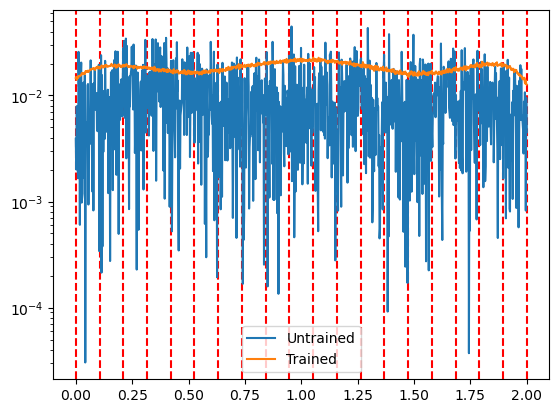

In [33]:
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

import nn_rbf
import torch

x_verification = torch.linspace(0, 2, 1000)
y_verification = fn_interpolate(x_verification)

with torch.no_grad():
    nn_interpolator_1 = nn_rbf.RBFInterpolant(x, eps, alphas=lda)
    nn_interpolator_2 = nn_rbf.RBFInterpolant(x, eps, alphas=lda_optimum) 
    for vertical in x:
        plt.axvline(vertical, color = "red", linestyle='--')

    plt.semilogy(x_verification, torch.abs(nn_interpolator_2(x_verification) - y_verification), label="Untrained")
    plt.semilogy(x_verification, torch.abs(nn_interpolator_1(x_verification) - y_verification), label="Trained")

    plt.legend()
    plt.show()

## Work with MSE loss function

In [35]:
import sys
sys.path.insert(0, '..')

import nn_rbf
import torch

# Use estimation of starting parameters
nn_interpolator = nn_rbf.RBFInterpolant(x, eps) 

Train model with MSE

In [38]:
max_iterations = 130000
# parameters_progress_mse = torch.zeros(size=(max_iterations, N), requires_grad = False)

mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=nn_interpolator.parameters(), lr=1e-1)
for i in range(max_iterations):
    loss = mse(nn_interpolator(x), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # parameters_progress_mse[i, :] = nn_interpolator.alphas
    print(f'{i}: {loss.item()}', end='\r')

Print computed parameters vs parameters by matrix inversion

In [39]:
print(nn_interpolator.alphas)
print(lda_optimum)

Parameter containing:
tensor([-35.5650, -13.3296,   3.1816,  13.8535,  20.0413,  21.6951,  20.3866,
         15.7899,   8.9337,   1.6576,  -6.5112, -14.0145, -20.4661, -24.4354,
        -25.6116, -21.8592, -12.6377,   1.4982,  23.0897,  52.7486],
       requires_grad=True)
tensor([  12579.5801,   -6380.8369,  -27667.5879,     392.4058,    6850.6929,
          11713.0791,   35069.7773,   41596.6641,  -43123.0039, -110631.9844,
          25956.4922,   33884.6289,   42404.7500,  -26329.5723,   54827.9141,
         -13365.0430,  -70053.1016,   -6033.5640,   56518.3359,  -18185.6836])


Represent approximation to the exact parameters

/home/higlesias/tfm-experiments/interpolation_comparison/rbf/alternative_functional/../nn_rbf.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.nn.Parameter(torch.tensor(alphas))


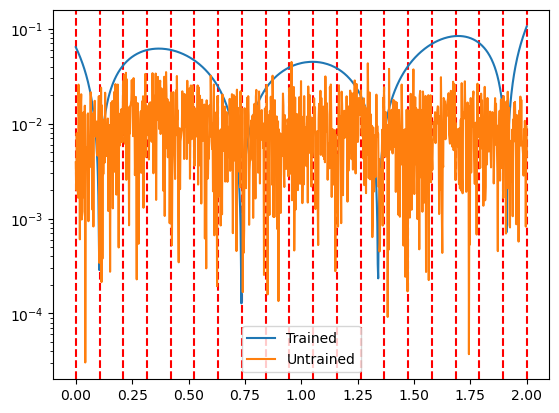

In [41]:
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

import nn_rbf
import torch

x_verification = torch.linspace(0, 2, 1000)
y_verification = fn_interpolate(x_verification)

with torch.no_grad():
    # nn_interpolator_1 = nn_rbf.RBFInterpolant(x, eps, alphas=lda)
    nn_interpolator_2 = nn_rbf.RBFInterpolant(x, eps, alphas=lda_optimum) 
    for vertical in x:
        plt.axvline(vertical, color = "red", linestyle='--')

    plt.semilogy(x_verification, torch.abs(nn_interpolator(x_verification) - y_verification), label="Trained")
    plt.semilogy(x_verification, torch.abs(nn_interpolator_2(x_verification) - y_verification), label="Untrained")

    plt.legend()
    plt.show()